In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [2]:
from blocks.get_raw_df import get_raw_df

2024-10-13 23:28:29,413 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-10-13 23:28:29,413 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-10-13 23:28:29,429 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-10-13 23:28:29,445 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-10-13 23:28:29,455 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-10-13 23:28:29,455 INFO sqlalchemy.engine.Engine [raw sql] {}


In [3]:
import numpy as np

In [19]:
df = get_raw_df()

2024-10-13 23:35:13,294 INFO sqlalchemy.engine.Engine select * from ane_base.parser_app_pricesraw
2024-10-13 23:35:13,296 INFO sqlalchemy.engine.Engine [raw sql] {}


In [54]:
site_links_end = df[df.date=='2024-10-09'].site_link.unique()
site_links_start = df[df.date=='2019-01-31'].site_link.unique()
site_links = np.intersect1d(site_links_start, site_links_end)
raw_df = df[df.site_link.isin(site_links)]


raw_df = raw_df.sort_values('date').reset_index(drop=True)

In [55]:
# raw_df = raw_df[raw_df.date.dt.weekday==6]

In [56]:
raw_df = raw_df.set_index('date')

In [57]:
raw_df.price_old = raw_df.price_old.astype(float)

In [58]:
raw_df.loc[raw_df.price_old!=-1, 'price_new'] = None
raw_df['price_new'] = raw_df.groupby('site_link')['price_new'].ffill()
raw_df['median_price'] = raw_df.groupby(['date', 'category_id'])['price_new'].transform(lambda x: x.median())
raw_df['cnt_products'] = raw_df.groupby(['date', 'category_id'])['site_link'].transform(lambda x: x.nunique())
raw_df['price_ratio'] = raw_df.price_new / raw_df.median_price
raw_df['is_price_change'] = raw_df.groupby('site_link')['price_new'].transform(lambda x: (x.pct_change()!=0)&(x.pct_change().notna()))

raw_df = raw_df[['price_new', 'price_old', 'is_price_change',
                 'site_link', 'category_id', 'cnt_products', 'median_price', 'price_ratio']]

In [59]:
raw_df['is_future_change'] = raw_df.groupby('site_link')['is_price_change'].transform(lambda x: x.shift(-1))

In [60]:
probs = dict()
for i in range(0, 200, 1):
    upper_bound = i/100
    lower_bound = i/100-0.01
    sub_df = raw_df[(raw_df.price_ratio>=lower_bound)&(raw_df.price_ratio<=upper_bound)]
    prob = sub_df.is_future_change.sum()/sub_df.is_future_change.count()

    probs[i/100-1] = prob

C:\Users\user\AppData\Local\Temp\ipykernel_12292\1253377458.py:6: RuntimeWarning: invalid value encountered in scalar divide
  prob = sub_df.is_future_change.sum()/sub_df.is_future_change.count()


In [61]:
bins = list(map(lambda x: x/100, list(range(0,200,1))))
# df.plot(kind='bar')

In [62]:
cng_df = raw_df.groupby(pd.cut(raw_df['price_ratio'], bins=bins))['is_future_change'].agg([lambda x: x.sum()/x.count() if x.sum()!=0 else 0, lambda x: x.count()])
cng_df.columns = ['prob', 'cnt']

C:\Users\user\AppData\Local\Temp\ipykernel_12292\3961533533.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cng_df = raw_df.groupby(pd.cut(raw_df['price_ratio'], bins=bins))['is_future_change'].agg([lambda x: x.sum()/x.count() if x.sum()!=0 else 0, lambda x: x.count()])


In [74]:
cng_df['prob'].index = list(map(lambda x: x/100, list(range(0, 199))))

In [80]:
cng_df['prob'].to_excel('prob.xlsx')#.plot(kind='bar')

<BarContainer object of 191 artists>

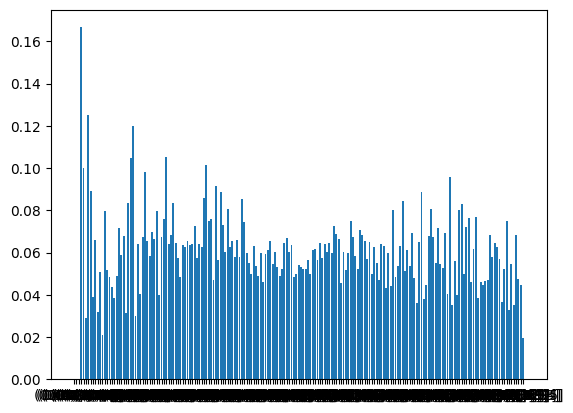

In [75]:
plt.bar(x=list(map(lambda x: str(x), cng_df.iloc[4:-4]['prob'].index)), height=cng_df['prob'].iloc[4:-4].values)

In [114]:
categories = pd.read_csv(r'data\categories_types.csv', sep='\t', encoding = "cp1251", index_col=0, decimal=',')

In [115]:
categories = categories.iloc[:,:-1]

In [117]:
raw_df = raw_df.merge(categories, left_on='category_id', right_index=True)

In [119]:
raw_df.loc[:, 'is_price_change'] = raw_df.is_price_change.astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_12292\3491714684.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  raw_df.loc[:, 'is_price_change'] = raw_df.is_price_change.astype(int)


In [120]:
raw_df

,price_new,price_old,is_price_change,site_link,category_id,cnt_products,median_price,price_ratio,is_future_change,cat_title,type_1,type_2,type_3
date,,,,,,,,,,,,,
2019-01-31,72.9,-1.00,0,https://www.vprok.ru/product/domik-v-derevne-d...,10,5,115.0,0.633913,False,"Молоко питьевое цельное пастеризованное 2,5-3,...",Молочные продукты и яйца,Продукты недлительного хранения,Необработанные продукты
2019-01-31,48.9,-1.00,0,https://www.vprok.ru/product/agroperspektiva-t...,15,3,60.9,0.802956,False,Сахар-песок,Сахар-песок,Продукты длительного хранения,Обработанные продукты
2019-01-31,69.9,-1.00,0,https://www.vprok.ru/product/ogurtsy-dlinnye-1...,26,4,159.0,0.439623,False,Огурцы свежие,Овощи,Продукты недлительного хранения,Необработанные продукты
2019-01-31,63.9,-1.00,0,https://www.vprok.ru/product/sarafanovo-sarafa...,10,5,115.0,0.555652,False,"Молоко питьевое цельное пастеризованное 2,5-3,...",Молочные продукты и яйца,Продукты недлительного хранения,Необработанные продукты
2019-01-31,139.0,-1.00,0,https://www.vprok.ru/product/ogurtsy-fasovanny...,26,4,159.0,0.874214,False,Огурцы свежие,Овощи,Продукты недлительного хранения,Необработанные продукты
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-13,94.9,94.90,0,https://www.vprok.ru/product/domik-v-derevne-s...,11,7,109.0,0.870642,NaN,Сметана,Молочные продукты и яйца,Продукты недлительного хранения,Обработанные продукты
2024-10-13,109.0,-1.00,0,https://www.vprok.ru/product/prostokvashino-pr...,11,7,109.0,1.000000,NaN,Сметана,Молочные продукты и яйца,Продукты недлительного хранения,Обработанные продукты
2024-10-13,89.9,-1.00,0,https://www.vprok.ru/product/rostagroeksport-r...,11,7,109.0,0.824771,NaN,Сметана,Молочные продукты и яйца,Продукты недлительного хранения,Обработанные продукты


In [42]:
# raw_df['price_pct_change'] = raw_df.groupby('site_link')['price_new'].transform(lambda x: x.pct_change())
# raw_df[raw_df.date.between('2022-01-01', '2022-12-31')].groupby('date').apply(lambda x: x[x.price_pct_change>0].is_price_change.sum()/x.is_price_change.count()).rolling(15).mean().plot()
# raw_df[raw_df.date.between('2021-01-01', '2021-12-31')].groupby('date').apply(lambda x: x[x.price_pct_change>0].is_price_change.sum()/x.is_price_change.count()).rolling(15).mean().plot()
# raw_df[raw_df.date.between('2020-01-01', '2020-12-31')].groupby('date').apply(lambda x: x[x.price_pct_change>0].is_price_change.sum()/x.is_price_change.count()).rolling(15).mean().plot()
